In [44]:
import(Plots)

In [323]:
import(JSON)

In [828]:
# Graph the graph
function graphplot(graph, chains)
    fig = Plots.plot(legend=false, aspect_ratio=:equal)
    #scatter!(coords[:, 1], coords[:, 2], linewidth=2)
    for chain in chains
        chain_xy = map(x -> graph[x].position, chain);
        filter!(xy -> ~isnothing(xy), chain_xy)
        if length(chain_xy) > 0
            x = getindex.(chain_xy, 1)
            y = getindex.(chain_xy, 2)
            Plots.plot!(x, y, linewidth=3)
            end;
        #println(coords[idx, 1])
        end;
    fig
    end;

In [367]:
## Force Layout 
const EPSILON = 1e-5

# Spring (+2 power)
function spring_energy(u, v)
    return (u^2 + v^2)
    end;
function spring_gradient(u, v)
    return (2*u, 2*v)
    end;

# Electric  (-2 power)
function repulsive_Coulomb_energy(u, v)
    return 1/(u^2 + v^2 + EPSILON)
    end;
function repulsive_Coulomb_gradient(u, v)
    d4 = (u^2 + v^2 + EPSILON)^2
    return (-2*u/d4, -2*v/d4)
    end;

# Inverse distance (-1 power)
function inverse_dist_energy(u, v)
    return 1/sqrt(u^2 + v^2 + EPSILON)
    end;

function inverse_dist_gradient(u, v)
    d3 = sqrt(u^2 + v^2 + EPSILON)^3
    return (-u/d3, -4*v/d3)
    end;

# The (attraction,repulsion)-model of ForceAtlas (1,-1)
# has an intermediate position between Noack’s LinLog (0,-1)
# and the algorithm of Fruchterman and Rheingold (2,-1),
# https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0098679&type=printable

attractive_energy = spring_energy
attractive_gradient = spring_gradient
repulsive_energy = repulsive_Coulomb_energy
repulsive_gradient = repulsive_Coulomb_gradient

repulsive_Coulomb_gradient (generic function with 1 method)

In [13]:
using(BenchmarkTools)

In [14]:
mutable struct Node
    neighbors
    position #::Union{Nothing, Tuple{Float64, Float64}}
    velocity
    force
    energy
    previous_position
    previous_velocity
    previous_force
    previous_energy
    end;

Node() = Node([], nothing, nothing, nothing, nothing,
                  nothing, nothing, nothing, nothing)

Node

In [854]:
function compute_force!(graph, node_name)
    node = graph[node_name]
    if isnothing(node.position)
        return
        end;
    node.force = (.0, .0)
    # Pairs and triplet
    for (left, right) in node.neighbors
        if ~isnothing(left) && ~isnothing(graph[left].position)
            # and coords is not nothing (?) for partial graph
            u_left = node.position .- graph[left].position
            node.force = node.force .- attractive_gradient(u_left...)
            end;
        if ~isnothing(right) && ~isnothing(graph[right].position)
            u_right = node.position .- graph[right].position
            node.force = node.force .- attractive_gradient(u_right...)
            end;
        if ~isnothing(left) && ~isnothing(right)
            # moment 
            end;
        end;

    # All
    for (name, other_node) in pairs(graph)
        if name == node_name || isnothing(other_node.position)
            continue
        else
            u = node.position .- other_node.position
            node.force = node.force .- repulsive_Coulomb_gradient(u...)
            end;
        end;
    end;

In [855]:
function compute_all_force!(graph)
    for node_name in keys(graph)
        compute_force!(graph, node_name)
        end;
    end;

In [ ]:
update_force!(graph, nodes)

for node_name in nodes
    compute_force!(graph, node_name)
    end;


In [420]:
# init graph data structure
function create_graph(chains)
    graph = Dict()
    for chain in chains
        node = get!(graph, chain[1], Node())
        push!(node.neighbors, (nothing, chain[2]))

        for k in 2:length(chain)-1
            node = get!(graph, chain[k], Node())
            push!(node.neighbors, (chain[k-1], chain[k+1]))
            end;

        node = get!(graph, chain[end], Node())
        push!(node.neighbors, (chain[end-1], nothing))
        end;
    
    return graph
    end;

function place_on_circle!(graph, node_ids)    
    # init coordinates (on a circle)
    N = length(node_ids)
    radius = N/(2*pi)
    delta_theta = 2*pi/N
    for (k, node_id) in enumerate(node_ids)
        node = graph[node_id]
        theta = k*delta_theta
        node.position = (radius*cos(theta), radius*sin(theta))
        node.previous_position = node.position
        node.velocity = (0.0, 0.0)
        node.previous_velocity = (0.0, 0.0)
        end;

    # init forces
    compute_all_force!(graph)
    
    # init previous forces
    for node in values(graph)
        node.previous_force = node.force
        end;
    
    end;

In [809]:
# Velocity Verlet
# http://students.iitk.ac.in/projects/wiki/lib/exe/fetch.php?media=2014as:verlet.pdf
function velocity_verlet!(graph, dt, nodes)
    dt2_2 = dt^2 / 2
    
    #nodes = filter(n -> ~isnothing(n.position), collect(values(graph)))
    # positions
    for node in nodes
        dX = (dt2_2).*node.force
        if norm(dX) > 7.0
            dX = 7 .* dX ./ norm(dX)
            end;
        node.position = node.position .+ dX
        node.previous_force = node.force
        end;
    
    # forces
    compute_all_force!(graph)

    # velocities
    for node in nodes
        node.velocity = node.velocity .+ (node.force .+ node.previous_force).*(0.5dt)    
        end;
    
    end;

In [810]:
dot(a, b) = sum(a .* b)
norm(a) = sqrt(dot(a, a))
unit_vector(a) = a./norm(a)

unit_vector (generic function with 1 method)

In [811]:
# https://github.com/mauro3/Parameters.jl
# import Pkg; Pkg.add("Parameters")
using Parameters

In [544]:
@with_kw mutable struct Fire
    N_min = 5
    f_inc = 1.1
    f_dec = 0.5
    alpha_start = 0.1
    f_alpha = 0.99
    dt_max = .5
    # variable
    dt = dt_max / 5.0
    N = 0
    alpha = alpha_start
end

Fire

In [812]:
# Fire minimization
# Bitzek, Erik, et al. "Structural relaxation made simple."
# Physical review letters 97.17 (2006): 170201.

function step!(graph, fire, nodes)
    
    # loop
    velocity_verlet!(graph, fire.dt, nodes)

    #nodes = filter(n -> ~isnothing(n.position), collect(values(graph)))
    P = sum( dot(node.force, node.velocity) for node in nodes )

    for node in nodes
        hat_F = unit_vector(node.force)
        v = node.velocity
        node.velocity = (1 - fire.alpha).*v .+ (fire.alpha * norm(v)).*hat_F  
        end;

    if P > 0 && fire.N > fire.N_min
        fire.dt = min(fire.f_inc*fire.dt, fire.dt_max)
        fire.alpha = fire.alpha * fire.f_alpha
        fire.N = 0
    elseif P > 0
        fire.N += 1
        end;
    
    if P <= 0
        fire.dt = fire.f_dec * fire.dt
        fire.alpha = fire.alpha_start
        foreach(node -> node.velocity = (0.0, 0.0), nodes)
        fire.N = 0
        end;

    end;

In [813]:
# test graph
chains = [["A", "B", "C", "D", "E"],
          ["R", "E", "T", "ER", "erz", "ZE"],
          ["C", "re", "eze"]]

graph = create_graph(chains)

place_on_circle!(graph, chains[1])

In [822]:
# ====================
# Load graph from Json
files = filter(x -> endswith(x, "_chains.json"), readdir("./data/"))

println(files)

file_name = files[3]
path = string("./data/", file_name)
data = read(path, String)
d = []
chains = JSON.parse(data, dicttype=Array{Array{String}});
sort!(chains, by=x->length(x), rev=true)
println("number of chains: ", length(chains))

graph = create_graph(chains);
place_on_circle!(graph, chains[1])

["162509553_129_chains.json", "177539135_99_chains.json", "232479038_123_chains.json"]
number of chains: 18


In [799]:
println("max force ", max_force(graph))

max force 2.0351845999350866


In [823]:
# Global optim
function global_optim!(graph)
    fire = Fire(dt_max=1.00)
    nodes = filter(n -> ~isnothing(n.position), collect(values(graph)))
    for k in 1:100
        step!(graph, fire, nodes)
        end;
    end;

In [824]:
# Local opti
function add_a_node!(graph)
    new_node = place_a_node!(graph)
    compute_all_force!(graph)
    #print(new_node, " ")

    fire = Fire(dt_max=1.0)
    for k in 1:100
        step!(graph, fire, [graph[new_node], ])
        end;
    end;

In [852]:
for k = 1:20
    print(k, "           \r")
    add_a_node!(graph);
    global_optim!(graph);
    end;

KeyError: KeyError: key nothing not found

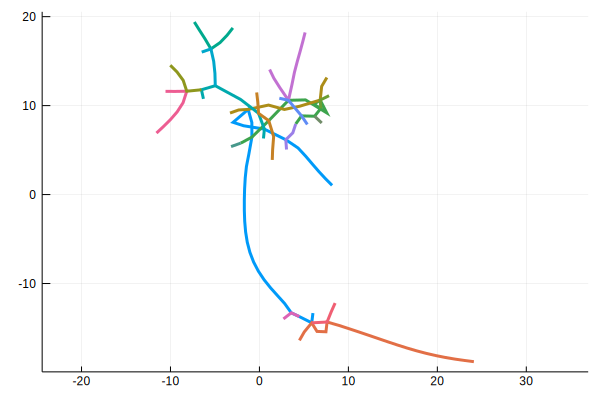

In [853]:
#add_a_node!(graph);
global_optim!(graph);
graphplot(graph, chains)

In [731]:
function max_force(graph)
    maximum(x -> norm(x.force),
            filter(x -> ~isnothing(x.position), collect(values(graph))))
    end;

In [794]:
function place_a_node!(graph)
    new_node = nothing
    for node in values(graph), neighbors in node.neighbors, neighbour in neighbors
        if isnothing(node.position)
            continue
            end;
        if ~isnothing(neighbour) && isnothing(graph[neighbour].position)
            graph[neighbour].position = node.position .+ (0.3, 0.0)
            graph[neighbour].previous_position = graph[neighbour].position
            graph[neighbour].velocity = (0.0, 0.0)
            graph[neighbour].previous_velocity = (0.0, 0.0)
            new_node = neighbour
            break
            end;
        end;
    return new_node
    end;


In [856]:
## Stillou Webou
const coeff = 4.1
function three_body_energy(x0, x1, x2, x3, x4, x5)
    u0 = -x0 + x2
    u1 = -x1 + x3
    u2 = -x2 + x4
    u3 = -x3 + x5
    return coeff*(-1 + (u0*u2 + u1*u3)/sqrt( (u0^2 + u1^2)*(u2^2 + u3^2) ))^2
    end;

function three_body_gradient(x0, x1, x2, x3, x4, x5)
    u0 = -x0 + x2
    u1 = -x2
    u2 = u1 + x4
    u3 = -x1 + x3
    u4 = -x3
    u5 = u4 + x5
    u6 = u0*u2 + u3*u5
    u7 = u0^2 + u3^2
    u8 = 1/sqrt(u7)
    u9 = u2^2 + u5^2
    u10 = 1/sqrt(u9)
    u11 = u10*u8
    u12 = u11*u6 - 1
    u13 = x2 - x4
    u14 = 2*u11
    u15 = 2*u6
    u16 = u10*u15/u7^(3/2)
    u17 = x3 - x5
    u18 = u15*u8/u9^(3/2)
     
    return (u12*(u0*u16 + u13*u14), 
            u12*(u14*u17 + u16*u3), 
            u12*(u14*(x0 - 2*x2 + x4) + u16*(u1 + x0) + u18*u2), 
            u12*(u14*(x1 - 2*x3 + x5) + u16*(u4 + x1) + u18*u5), 
            u12*(u0*u14 + u13*u18), 
            u12*(u14*u3 + u17*u18) ).*(coeff)
    end;

In [902]:
@benchmark (x)^(3/2) setup=(x=rand())

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     68.175 ns (0.00% GC)
  median time:      76.779 ns (0.00% GC)
  mean time:        76.973 ns (0.00% GC)
  maximum time:     148.875 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     973

In [901]:
@benchmark sqrt(x)^3 setup=(x=rand())

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     7.191 ns (0.00% GC)
  median time:      7.384 ns (0.00% GC)
  mean time:        7.639 ns (0.00% GC)
  maximum time:     27.713 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     999

In [928]:
norm2(u) = sum( u.^2 );

In [946]:
function three_body_gradient2(u, v)

    n2_u = norm2(u)
    n2_v = norm2(v)
    cross = u[1]*v[2] - u[2]*v[1]

    cross_nunv = cross / sqrt( n2_u * n2_v )
    u3 = cross_nunv / n2_u
    u4 = cross_nunv / n2_v

    return (u3*u[2], -u3*u[1]), (-u4*v[2], u4*v[1])
    end;

In [957]:
function three_body_gradient3(u, v)
    x1, y1 = u
    x2, y2 = v
    n2_u = x1^2 + y1^2
    n2_v = x2^2 + y2^2
    cross = x1*y2 - x2*y1

    cross_nunv = cross / sqrt( n2_u * n2_v )
    u3 = cross_nunv / n2_u
    u4 = cross_nunv / n2_v

    return (u3*y1, -u3*x1), (-u4*y2, u4*x2)
    end;

In [958]:
u = Tuple(rand(2))
v = Tuple(rand(2))

(0.3554843703280557, 0.601980300711811)

In [959]:
three_body_gradient3((1.0, -0.1), (-1.0, -0.1))

((0.019605920988138417, 0.19605920988138417), (-0.019605920988138417, 0.19605920988138417))

In [993]:
distance1(u, v) = sqrt( sum( (u .- v).^2 ) )
function distance2(u, v)
    x, y = u
    x1, y1 = v
    
    return sqrt((x - x1)^2 + (y - y1)^2)
    end;

function distance3(x, y, x1, y1)
    #x, y = u
    #x1, y1 = v
    
    return sqrt((x - x1)^2 + (y - y1)^2)
    end;


In [989]:
@benchmark distance1(u, v) setup=(u=rand(2); v=rand(2))

BenchmarkTools.Trial: 
  memory estimate:  96 bytes
  allocs estimate:  1
  --------------
  minimum time:     40.721 ns (0.00% GC)
  median time:      46.164 ns (0.00% GC)
  mean time:        72.466 ns (30.23% GC)
  maximum time:     6.706 μs (98.60% GC)
  --------------
  samples:          10000
  evals/sample:     991

In [990]:
@benchmark distance2(u, v) setup=(u=Tuple(rand(2)); v=Tuple(rand(2)))

BenchmarkTools.Trial: 
  memory estimate:  16 bytes
  allocs estimate:  1
  --------------
  minimum time:     23.362 ns (0.00% GC)
  median time:      25.364 ns (0.00% GC)
  mean time:        29.560 ns (9.65% GC)
  maximum time:     4.426 μs (99.26% GC)
  --------------
  samples:          10000
  evals/sample:     996

In [991]:
@benchmark distance4(u, v) setup=(u=rand(2); v=rand(2))

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     6.817 ns (0.00% GC)
  median time:      6.822 ns (0.00% GC)
  mean time:        7.115 ns (0.00% GC)
  maximum time:     36.926 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1000

In [985]:
@benchmark distance2(u, v) setup=(u=Tuple(rand(2)); v=Tuple(rand(2)))

BenchmarkTools.Trial: 
  memory estimate:  16 bytes
  allocs estimate:  1
  --------------
  minimum time:     23.905 ns (0.00% GC)
  median time:      26.117 ns (0.00% GC)
  mean time:        30.061 ns (9.32% GC)
  maximum time:     4.215 μs (99.17% GC)
  --------------
  samples:          10000
  evals/sample:     996

In [ ]:
@benchmark distance3(u..., v...) setup=(u=rand(2); v=rand(2))

In [996]:
@benchmark distance3(a, b, c, d) setup=(a=rand(); b=rand(); c=rand(); d=rand())

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     6.818 ns (0.00% GC)
  median time:      7.285 ns (0.00% GC)
  mean time:        7.146 ns (0.00% GC)
  maximum time:     26.314 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1000

In [960]:
@benchmark three_body_gradient3(u, v) setup=(u=rand(2); v=rand(2))

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     22.024 ns (0.00% GC)
  median time:      22.048 ns (0.00% GC)
  mean time:        23.080 ns (0.00% GC)
  maximum time:     53.119 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     996

In [978]:
@code_warntype distance2(rand(2), rand(2))

Variables
  #self#::Core.Compiler.Const(distance2, false)
  u::Array{Float64,1}
  v::Array{Float64,1}
  x::Float64
  @_5::Int64
  y::Float64
  x1::Float64
  @_8::Int64
  y1::Float64

Body::Float64
1 ─ %1  = Base.indexed_iterate(u, 1)::Core.Compiler.PartialStruct(Tuple{Float64,Int64}, Any[Float64, Core.Compiler.Const(2, false)])
│         (x = Core.getfield(%1, 1))
│         (@_5 = Core.getfield(%1, 2))
│   %4  = Base.indexed_iterate(u, 2, @_5::Core.Compiler.Const(2, false))::Core.Compiler.PartialStruct(Tuple{Float64,Int64}, Any[Float64, Core.Compiler.Const(3, false)])
│         (y = Core.getfield(%4, 1))
│   %6  = Base.indexed_iterate(v, 1)::Core.Compiler.PartialStruct(Tuple{Float64,Int64}, Any[Float64, Core.Compiler.Const(2, false)])
│         (x1 = Core.getfield(%6, 1))
│         (@_8 = Core.getfield(%6, 2))
│   %9  = Base.indexed_iterate(v, 2, @_8::Core.Compiler.Const(2, false))::Core.Compiler.PartialStruct(Tuple{Float64,Int64}, Any[Float64, Core.Compiler.Const(3, false)])
│        

In [881]:
function reset_forces!(graph)
    for node in values(graph)
        if ~isnothing(node.position)
            node.previous_force = node.force;
            node.force = (0.0, 0.0);
            end;
        end;
    end;

In [882]:
n = graph["AAC_2014_184939712"];
println(n)

Node(Any[("SM_2014_196480582", "CMS_2014_195543025")], (-0.11749145747489273, -8.613983940894427), (0.0441738467652383, 0.09753262575871333), (0.011039322365081983, 0.024032006302596498), nothing, (0.24990560446932542, -5.246164259292811), (0.0, 0.0), (0.011018930941714244, 0.02405216719669001), nothing)


In [897]:
# Spring (+2 power)
# F = (-x, -y)
spring_force(u) = -2 .* u;

In [885]:
for node in values(graph)
    if isnothing(node.position)
        continue
        end;
    
    for (left_name, right_name) in node.neighbors
        if !isnothing(left_name) && !isnothing(graph[left_name].position)
            left = graph[left]
            # Compute pair force
            u = node.position .- left.position
            F = spring_force(u)
            left.force = left.force .- F
            node.force = node.force .+ F
            
            if !isnothing(right_name) && !isnothing(graph[right_name].position)
                right = graph[right]
                v = right.position .- node.position
                # Compute triplet force
                
        println(left, "  ", right)
        end;
        end;

SM_2014_196480582  CMS_2014_195543025
VM_2001_178135232  RR_2003_070260753
ML_2012_177538619  CR_2013_177122986
GM_2008_131498746  DS_2014_195372778
AM_1999_103665013  CJE_2010_162509553
MI_2011_164630163  WZ_2012_164985085
MW_2017_221469125  

ArgumentError: ArgumentError: `nothing` should not be printed; use `show`, `repr`, or custom output instead.

In [ ]:
function graph_gradient!a(graph)
    
    # Linked
    for chain in graph.chains
        left, center = graph.nodes[chain[1]], graph.nodes[chain[2]]
        x1, y1 = coords[1, left], coords[2, left]
        x2, y2 = coords[1, center], coords[2, center]
        for k in 3:length(chain)
            right = graph.nodes[chain[k]]
            x3, y3 = coords[1, right], coords[2, right]
            
            # pair
            u = x2 - x1
            v = y2 - y1
            grad = attractive_gradient(u, v)
            
            G[1, left] -= grad[1]
            G[2, left] -= grad[2]
            G[1, center] += grad[1]
            G[2, center] += grad[2]
            
            # three body
            grad3 = three_body_gradient(x1, y1, x2, y2, x3, y3)
            
            G[1, left] += grad3[1]
            G[2, left] += grad3[2]
            G[1, center] += grad3[3]
            G[2, center] += grad3[4]
            G[1, right] += grad3[5]
            G[2, right] += grad3[6]
            
            left = center
            center = right
            x1, y1 = x2, y2
            x2, y2 = x3, y3
            end;
        
        # the last pair
        u = x2 - x1
        v = y2 - y1
        grad = attractive_gradient(u, v)

        G[1, left] -= grad[1]
        G[2, left] -= grad[2]
        G[1, center] += grad[1]
        G[2, center] += grad[2]
        
        end;
    
    # Repulsive
    # Todo: insert Barnes Hut here...
    for i in 1:length(graph.nodes)
        x1, y1 = coords[1, i], coords[2, i]
        for j in i+1:length(graph.nodes)
            x2, y2 = coords[1, j], coords[2, j]
            u = x2 - x1
            v = y2 - y1
            grad = repulsive_gradient(u, v)
            G[1, i] -= grad[1]
            G[2, i] -= grad[2]
            G[1, j] += grad[1]
            G[2, j] += grad[2]
            end;
        end;

    
    end;